<a href="https://colab.research.google.com/github/utkarsh-prakash/Anamoly-Detection/blob/main/Anomaly_Detection_with_LSTM_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/utkarsh-prakash/Anamoly-Detection/main/spx.csv', parse_dates=['date'], index_col='date')

In [3]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)
print(X_train.shape)

(7752, 30, 1)


In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(
  tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 9s 31ms/step - loss: 0.2692 - val_loss: 0.2404
Epoch 2/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1157 - val_loss: 0.2685
Epoch 3/10
218/218 [==============================] - 6s 27ms/step - loss: 0.1417 - val_loss: 0.1713
Epoch 4/10
218/218 [==============================] - 6s 27ms/step - loss: 0.1795 - val_loss: 0.1191
Epoch 5/10
218/218 [==============================] - 6s 27ms/step - loss: 0.1592 - val_loss: 0.1193
Epoch 6/10
218/218 [==============================] - 6s 27ms/step - loss: 0.2140 - val_loss: 0.0961
Epoch 7/10
218/218 [==============================] - 6s 27ms/step - loss: 0.1972 - val_loss: 0.1919
Epoch 8/10
218/218 [==============================] - 6s 27ms/step - loss: 0.2824 - val_loss: 0.1060
Epoch 9/10
218/218 [==============================] - 6s 27ms/step - loss: 0.1857 - val_loss: 0.1156
Epoch 10/10
218/218 [==============================] - 6s 27ms/step - loss: 0.2272 - val_lo

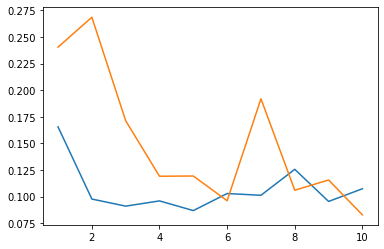

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1,len(loss)+1))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.show()

# Anomaly Detection

In [10]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



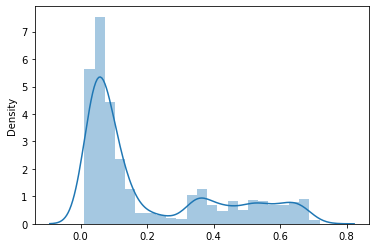

In [11]:
error = train_mae_loss[:, -1]

import seaborn as sns

sns.distplot(error)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



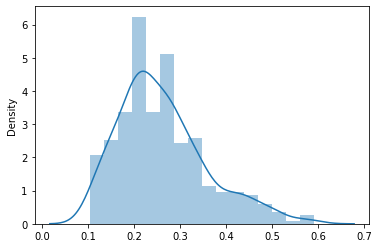

In [12]:
THRESHOLD = 0.4
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(test_mae_loss)
plt.show()

In [13]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

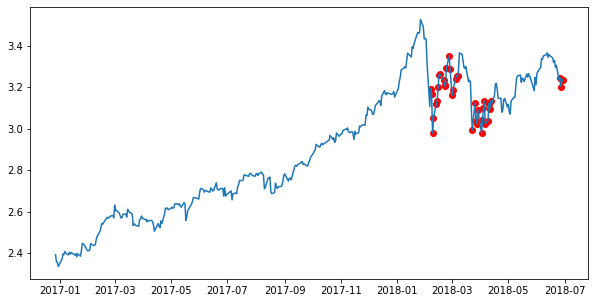

In [14]:
anomalies = test_score_df[test_score_df.anomaly == True]
fig = plt.figure(figsize=((10,5)))
plt.plot(test_score_df.reset_index()['date'].tolist(), test_score_df['close'].tolist())
plt.scatter(anomalies.reset_index()['date'].tolist(), anomalies['close'].tolist(), c='red')
plt.show()

In [15]:
train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
train_score_df['loss'] = train_mae_loss
train_score_df['threshold'] = THRESHOLD
train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
train_score_df['close'] = train[TIME_STEPS:].close

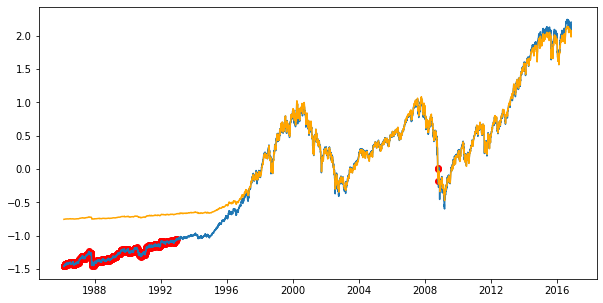

In [16]:
anomalies = train_score_df[train_score_df.anomaly == True]
fig = plt.figure(figsize=((10,5)))
plt.plot(train_score_df.reset_index()['date'].tolist(), train_score_df['close'].tolist())
plt.scatter(anomalies.reset_index()['date'].tolist(), anomalies['close'].tolist(), c='red')
plt.plot(train_score_df.reset_index()['date'].tolist(), X_train_pred[:,-1][:, -1], c='orange')
plt.show()

https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/

https://www.youtube.com/watch?v=H4J74KstHTE&list=PLdqO2JecEr7bPzq0b-q8OGvz3Fg-f3qhy&index=43